In [1]:
import os # tensorboardの出力先作成
import matplotlib.pyplot as plt # 可視化
import numpy as np # 計算
import torch # 機械学習フレームワークとしてpytorchを使用
import torch.nn as nn # クラス内で利用するモジュールのため簡略化
import torch.nn.functional as F # クラス内で利用するモジュールのため簡略化
from torch import optim # 最適化アルゴリズム
from torch.utils.tensorboard import SummaryWriter # tensorboardの利用
from torchvision import datasets, transforms # データセットの準備

In [2]:
# tensorboardのログの保存先
if not os.path.exists("./logs"):
    os.makedirs("./logs")

In [3]:
# MNISTのデータをとってくるときに一次元化する前処理
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

# trainデータとtestデータに分けてデータセットを取得
dataset_train_valid = datasets.MNIST("./", train=True, download=True, transform=transform)
dataset_test = datasets.MNIST("./", train=False, download=True, transform=transform)

# trainデータの20%はvalidationデータとして利用
size_train_valid = len(dataset_train_valid) # 60000
size_train = int(size_train_valid * 0.8) # 48000
size_valid = size_train_valid - size_train # 12000
dataset_train, dataset_valid = torch.utils.data.random_split(dataset_train_valid, [size_train, size_valid])

# 取得したデータセットをDataLoader化する
# バッチごとに取り出すことが目的
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1000, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1000, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1000, shuffle=False)

In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        """コンストラクタ

        Args:
            z_dim (int): 潜在空間の次元数

        Returns:
            None.

        Note:
            eps (float): オーバーフローとアンダーフローを防ぐための微小量
        """
        super(VAE, self).__init__() # VAEクラスはnn.Moduleを継承しているため親クラスのコンストラクタを呼ぶ必要がある
        self.eps = np.spacing(1) # オーバーフローとアンダーフローを防ぐための微小量
        self.x_dim = 28 * 28 # MNISTの場合は28×28の画像であるため
        self.z_dim = z_dim # インスタンス化の際に潜在空間の次元数は自由に設定できる
        self.enc_fc1 = nn.Linear(self.x_dim, 400) # エンコーダ1層目
        self.enc_fc2 = nn.Linear(400, 200) # エンコーダ2層目
        self.enc_fc3_mean = nn.Linear(200, z_dim) # 近似事後分布の平均
        self.enc_fc3_logvar = nn.Linear(200, z_dim) # 近似事後分布の分散の対数
        self.dec_fc1 = nn.Linear(z_dim, 200) # デコーダ1層目
        self.dec_fc2 = nn.Linear(200, 400) # デコーダ2層目
        self.dec_drop = nn.Dropout(p=0.2) # 過学習を防ぐために最終層の直前にドロップアウト
        self.dec_fc3 = nn.Linear(400, self.x_dim) # デコーダ3層目
        
    def encoder(self, x):
        """エンコーダ

        Args:
            x (torch.tensor): (バッチサイズ, 入力次元数)サイズの入力データ

        Returns:
            mean (torch.tensor): 近似事後分布の平均
            logvar (torch.tensor): 近似事後分布の分散の対数
        """
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        return self.enc_fc3_mean(x), self.enc_fc3_logvar(x)

    def sample_z(self, mean, log_var, device):
        """Reparameterization trickに基づく潜在変数Zの疑似的なサンプリング

        Args:
            mean (torch.tensor): 近似事後分布の平均
            logvar (torch.tensor): 近似事後分布の分散の対数
            device (String): GPUが使える場合は"cuda"でそれ以外は"cpu"

        Returns:
            z (torch.tensor): (バッチサイズ, z_dim)サイズの潜在変数
        """
        epsilon = torch.randn(mean.shape, device=device)

        return mean + epsilon * torch.exp(0.5 * log_var)
    def decoder(self, z):
        """デコーダ

        Args:
            z (torch.tensor): (バッチサイズ, z_dim)サイズの潜在変数

        Returns:
            y (torch.tensor): (バッチサイズ, 入力次元数)サイズの再構成データ
        """
        z = F.relu(self.dec_fc1(z))
        z = F.relu(self.dec_fc2(z))
        z = self.dec_drop(z)
        return torch.sigmoid(self.dec_fc3(z))

    def forward(self, x, device):
        """順伝播処理

        Args:
            x (torch.tensor): (バッチサイズ, 入力次元数)サイズの入力データ
            device (String): GPUが使える場合は"cuda"でそれ以外は"cpu"

        Returns:
            KL (torch.float): KLダイバージェンス
            reconstruction (torch.float): 再構成誤差
            z (torch.tensor): (バッチサイズ, z_dim)サイズの潜在変数
            y (torch.tensor): (バッチサイズ, 入力次元数)サイズの再構成データ            
        """
        mean, log_var = self.encoder(x.to(device)) # encoder部分
        z = self.sample_z(mean, log_var, device) # Reparameterization trick部分
        y = self.decoder(z) # decoder部分
        KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var)) # KLダイバージェンス計算
        reconstruction = torch.sum(x * torch.log(y + self.eps) + (1 - x) * torch.log(1 - y + self.eps)) # 再構成誤差計算
        return [KL, reconstruction], z, y

In [5]:
# GPUが使える場合はGPU上で動かす
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# VAEクラスのコンストラクタに潜在変数の次元数を渡す
model = VAE(2).to(device)

In [6]:
# 今回はoptimizerとしてAdamを利用
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 最大更新回数は1000回
num_epochs = 1000
# 検証データのロスとその最小値を保持するための変数を十分大きな値で初期化しておく
loss_valid = 10 ** 7
loss_valid_min = 10 ** 7
# early stoppingを判断するためのカウンタ変数
num_no_improved = 0
# tensorboardに記録するためのカウンタ変数
num_batch_train = 0
num_batch_valid = 0
# tensorboardでモニタリングする
writer = SummaryWriter(log_dir="./logs")

In [7]:
# 学習開始
for num_iter in range(num_epochs):
    model.train() # 学習前は忘れずにtrainモードにしておく
    for x, t in dataloader_train: # dataloaderから訓練データを抽出する
        lower_bound, _, _ = model(x, device) # VAEにデータを流し込む
        loss = -sum(lower_bound) # lossは負の下限
        model.zero_grad() # 訓練時のpytorchのお作法
        loss.backward()
        optimizer.step()
        writer.add_scalar("Loss_train/KL", -lower_bound[0].cpu().detach().numpy(), num_iter + num_batch_train)
        writer.add_scalar("Loss_train/Reconst", -lower_bound[1].cpu().detach().numpy(), num_iter + num_batch_train)
        num_batch_train += 1
    num_batch_train -= 1 # 次回のエポックでつじつまを合わせるための調整

    # 検証開始
    model.eval() # 検証前は忘れずにevalモードにしておく
    loss = []
    for x, t in dataloader_valid: # dataloaderから検証データを抽出する
        lower_bound, _, _ = model(x, device) # VAEにデータを流し込む
        loss.append(-sum(lower_bound).cpu().detach().numpy())
        writer.add_scalar("Loss_valid/KL", -lower_bound[0].cpu().detach().numpy(), num_iter + num_batch_valid)
        writer.add_scalar("Loss_valid/Reconst", -lower_bound[1].cpu().detach().numpy(), num_iter + num_batch_valid)
        num_batch_valid += 1
    num_batch_valid -= 1 # 次回のエポックでつじつまを合わせるための調整
    loss_valid = np.mean(loss)
    loss_valid_min = np.minimum(loss_valid_min, loss_valid)
    print(f"[EPOCH{num_iter + 1}] loss_valid: {int(loss_valid)} | Loss_valid_min: {int(loss_valid_min)}")

    # もし今までのlossの最小値よりも今回のイテレーションのlossが大きければカウンタ変数をインクリメントする
    if loss_valid_min < loss_valid:
        num_no_improved += 1
        print(f"{num_no_improved}回連続でValidationが悪化しました")
    # もし今までのlossの最小値よりも今回のイテレーションのlossが同じか小さければカウンタ変数をリセットする
    else:
        num_no_improved = 0
        torch.save(model.state_dict(), f"./z_{model.z_dim}.pth")
    # カウンタ変数が10回に到達したらearly stopping
    if (num_no_improved >= 10):
        print(f"{num_no_improved}回連続でValidationが悪化したため学習を止めます")
        break

# tensorboardのモニタリングも停止しておく
writer.close()

[EPOCH1] loss_valid: 203165 | Loss_valid_min: 203165
[EPOCH2] loss_valid: 190461 | Loss_valid_min: 190461
[EPOCH3] loss_valid: 178597 | Loss_valid_min: 178597
[EPOCH4] loss_valid: 173593 | Loss_valid_min: 173593
[EPOCH5] loss_valid: 170445 | Loss_valid_min: 170445
[EPOCH6] loss_valid: 168297 | Loss_valid_min: 168297
[EPOCH7] loss_valid: 166368 | Loss_valid_min: 166368
[EPOCH8] loss_valid: 164854 | Loss_valid_min: 164854
[EPOCH9] loss_valid: 163286 | Loss_valid_min: 163286
[EPOCH10] loss_valid: 161696 | Loss_valid_min: 161696
[EPOCH11] loss_valid: 160291 | Loss_valid_min: 160291
[EPOCH12] loss_valid: 158964 | Loss_valid_min: 158964
[EPOCH13] loss_valid: 157656 | Loss_valid_min: 157656
[EPOCH14] loss_valid: 156779 | Loss_valid_min: 156779
[EPOCH15] loss_valid: 156306 | Loss_valid_min: 156306
[EPOCH16] loss_valid: 154896 | Loss_valid_min: 154896
[EPOCH17] loss_valid: 154265 | Loss_valid_min: 154265
[EPOCH18] loss_valid: 153691 | Loss_valid_min: 153691
[EPOCH19] loss_valid: 152965 | Loss_v

In [8]:
# cd [プロジェクトへのパス]
# tensorboard --logdir ./logs

In [9]:
# 評価対象のモデルをインスタンス化する
model_z_2 = VAE(2)
model_z_10 = VAE(10)
model_z_20 = VAE(20)
model_z_2.load_state_dict(torch.load("./z_2.pth"))
model_z_10.load_state_dict(torch.load("./z_10.pth"))
model_z_20.load_state_dict(torch.load("./z_20.pth"))
# forループを回すためにモデルをリスト化する
model_list = [model_z_2.eval(), model_z_10.eval(), model_z_20.eval()]
# 可視化開始
for num_batch, data in enumerate(dataloader_test):
    fig, axes = plt.subplots(4, 10, figsize=(20, 4))
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]): 
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
    # まずは入力画像を描画
    for i, im in enumerate(data[0].view(-1, 28, 28)[:10]):
        axes[0][i].imshow(im, "gray")
    # z_dim=2, z_dim=10, z_dim=20の3つの学習済みVAEについて再構成画像を描画
    for i, model in enumerate(model_list):
        _, _, y = model(data[0], device)
        y = y.cpu().detach().numpy().reshape(-1, 28, 28)
        for j, im in enumerate(y[:10]):
            axes[i+1][j].imshow(im, "gray")
    fig.savefig(f"./reconstruction_{num_batch}.png")
    plt.close(fig)

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_5476/2579494027.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_z_2.load_state_dict(torch.load("./z_2.pt

FileNotFoundError: [Errno 2] No such file or directory: './z_10.pth'

In [11]:
z_dim = 2
model = VAE(z_dim)
model.load_state_dict(torch.load("./z_2.pth"))
cm = plt.get_cmap("tab10") # カラーマップの用意
# 可視化開始
for num_batch, data in enumerate(dataloader_test):
    fig_plot, ax_plot = plt.subplots(figsize=(9, 9))
    fig_scatter, ax_scatter = plt.subplots(figsize=(9, 9))
    # 学習済みVAEに入力を与えたときの潜在変数を抽出
    _, z, _ = model(data[0], device)
    z = z.detach().numpy()
    # 各クラスごとに可視化する
    for k in range(10):
        cluster_indexes = np.where(data[1].detach().numpy() == k)[0]
        ax_plot.plot(z[cluster_indexes,0], z[cluster_indexes,1], "o", ms=4, color=cm(k))
    fig_plot.savefig(f"./latent_space_z_{z_dim}_{num_batch}_plot.png")
    fig_scatter.savefig(f"./latent_space_z_{z_dim}_{num_batch}_scatter.png")
    plt.close(fig_plot)
    plt.close(fig_scatter)

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_5476/599316188.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./z_2.pth"))


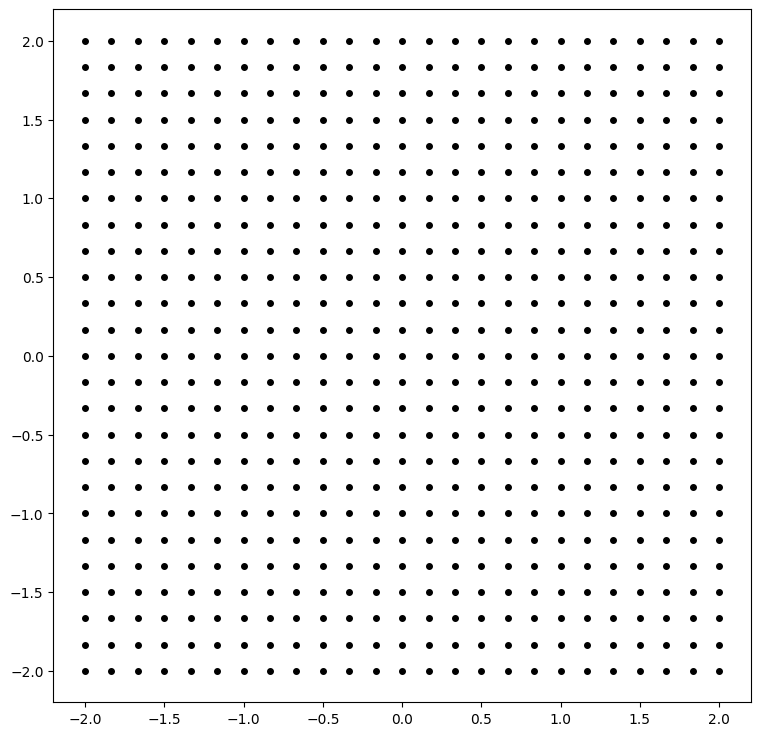

In [12]:
l = 25 # 一辺の生成画像数
# 横軸と縦軸を設定して格子点を生成
x = np.linspace(-2, 2, l)
y = np.linspace(-2, 2, l)
z_x, z_y = np.meshgrid(x, y)
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.plot(z_x, z_y, "o", ms=4, color="k")
fig.savefig("lattice_point.png")

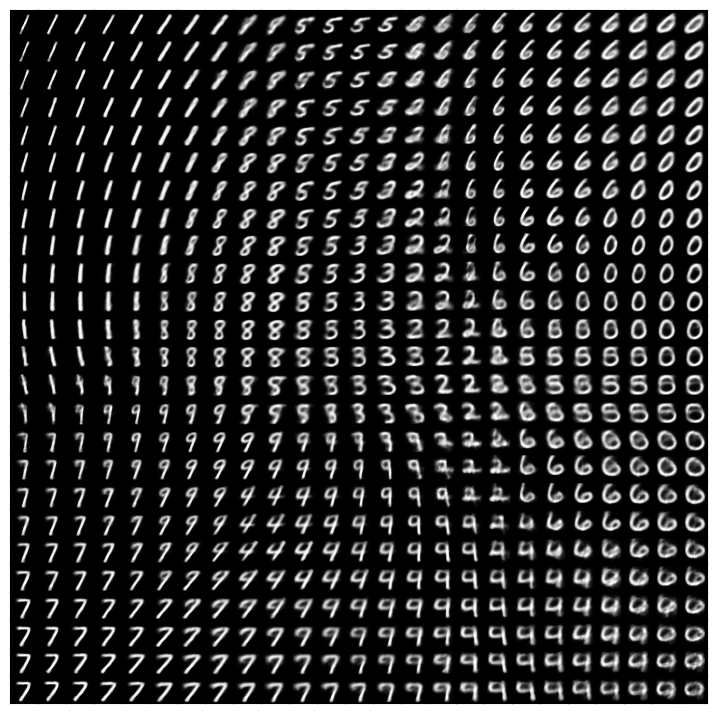

In [13]:
Z = torch.tensor(np.array([z_x, z_y]), dtype=torch.float).permute(1,2,0) # 格子点を結合して潜在変数とみなす
y = model_z_2.decoder(Z).cpu().detach().numpy().reshape(-1, 28, 28) # デコーダに潜在変数を入力
fig, axes = plt.subplots(l, l, figsize=(9, 9))
# 可視化開始
for i in range(l):
    for j in range(l):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].imshow(y[l * (l - 1 - i) + j], "gray")
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("from_lattice_point.png")

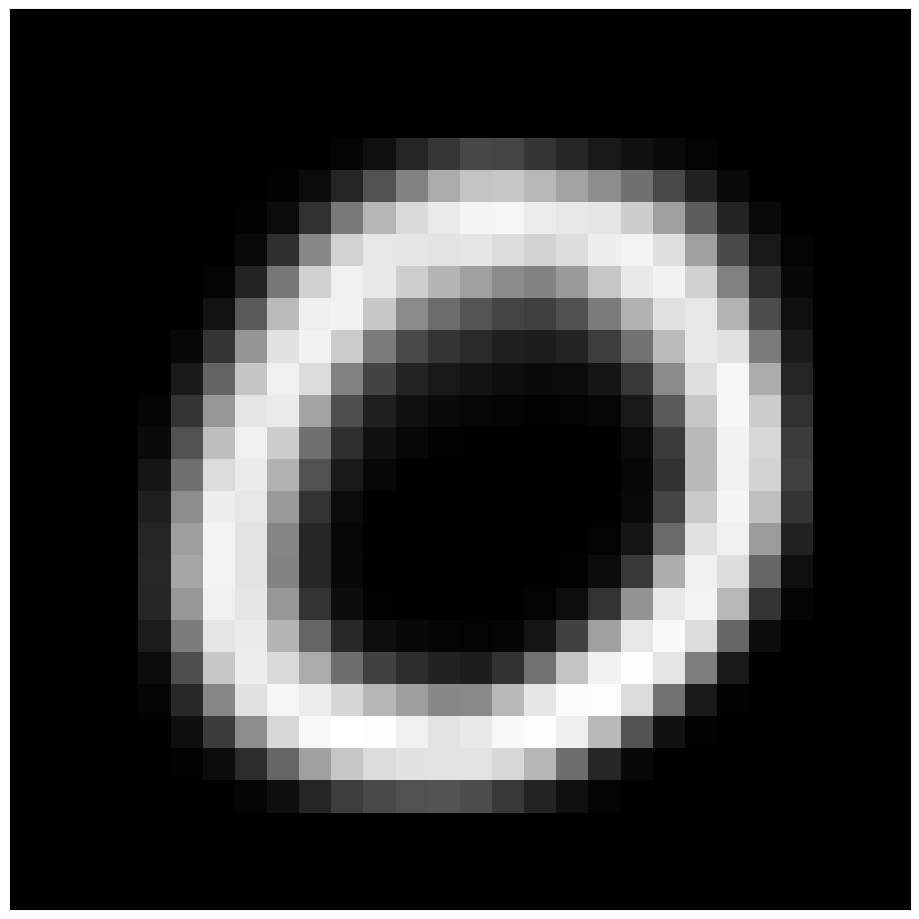

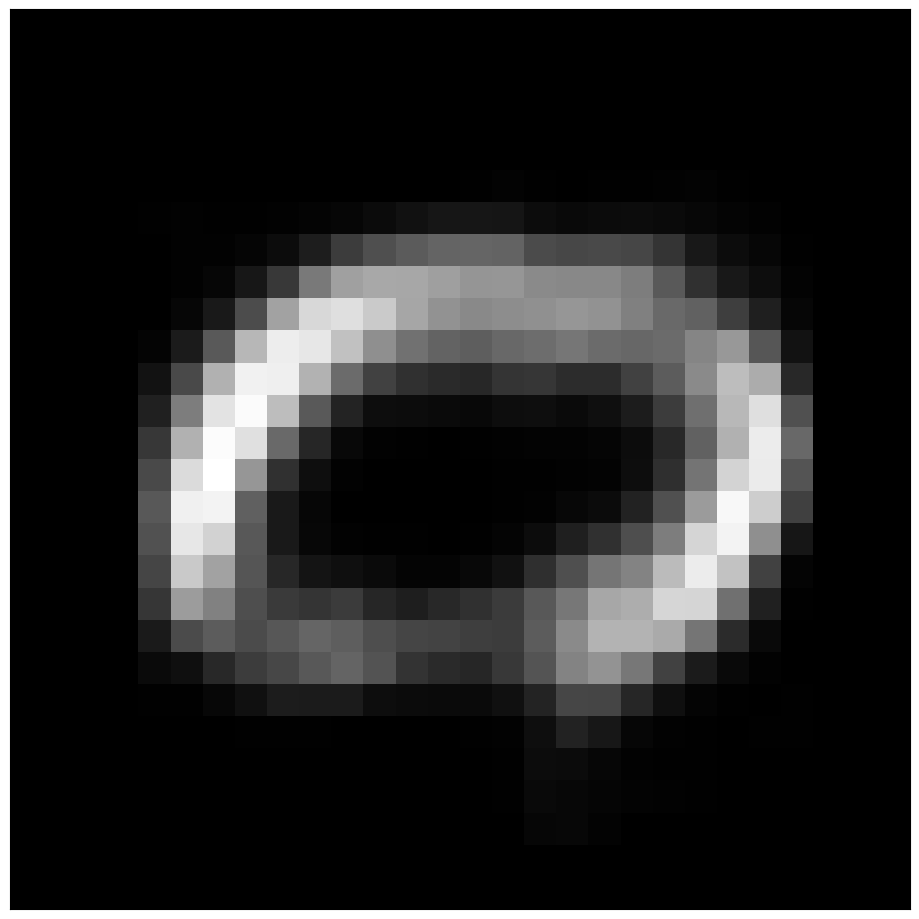

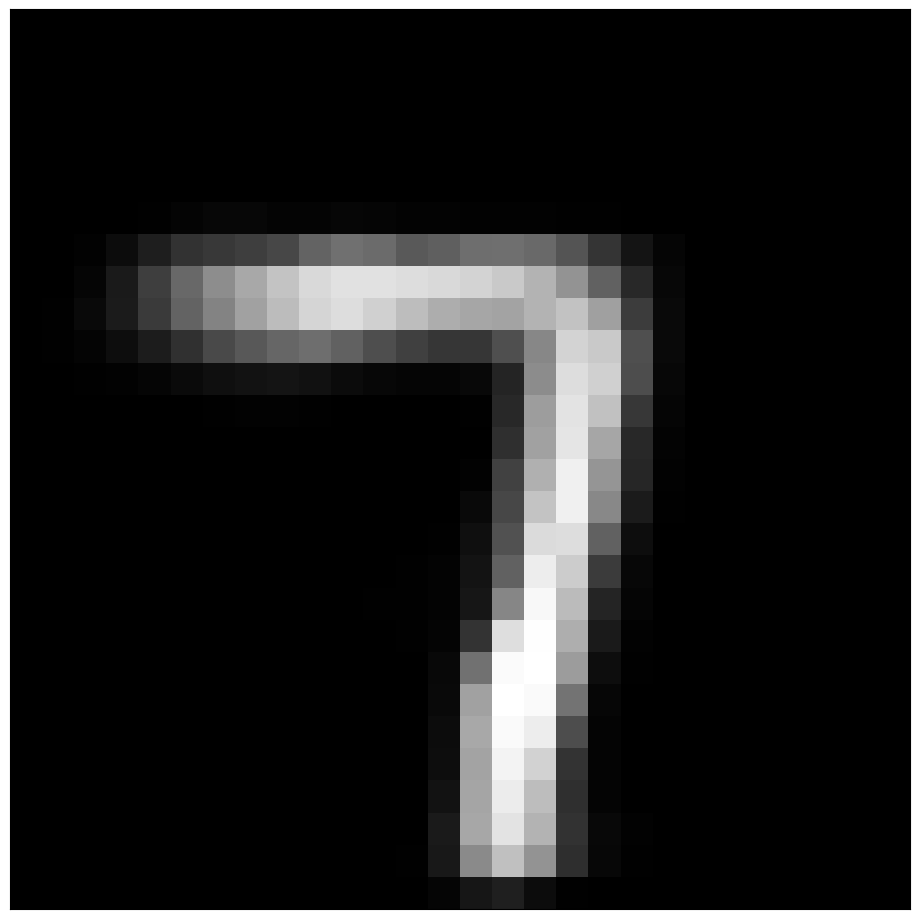

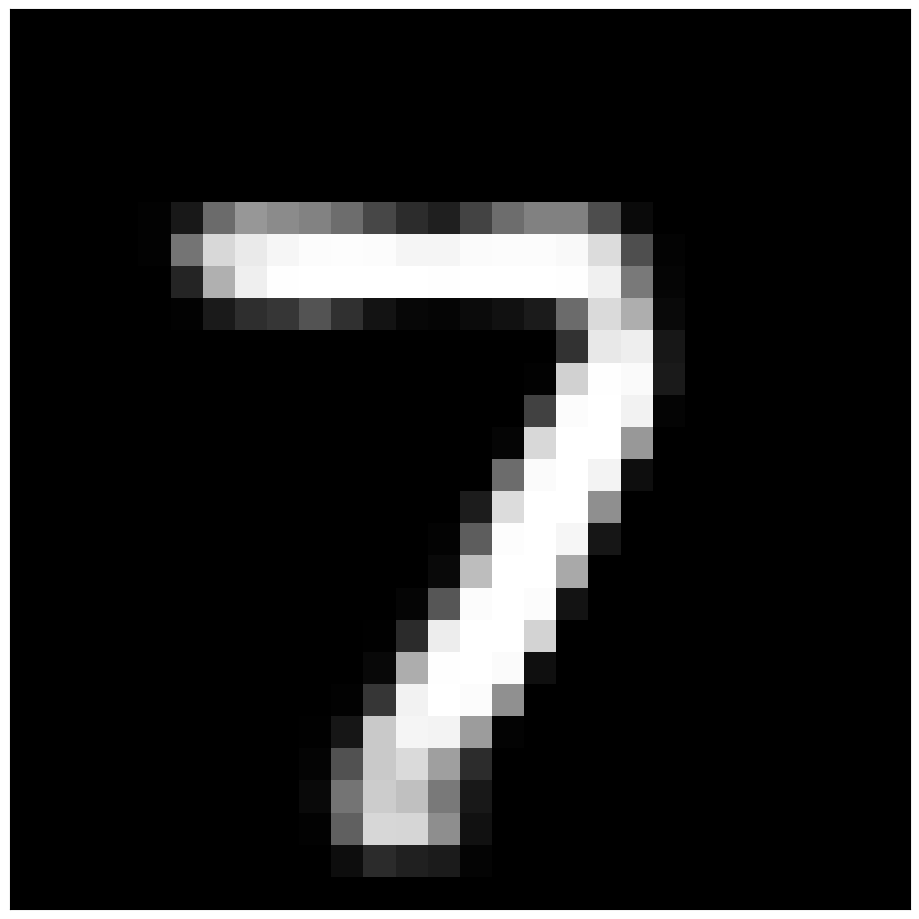

In [14]:
from matplotlib.animation import ArtistAnimation # gif作成のためにmatplotlibのモジュールを利用

step = 50 # 何枚の画像アニメーションに用いるか
z_dim = 2 # 潜在変数は2
# 4つの方向のスタート地点とゴール地点を座標で定義
z11 = torch.tensor([-3, 0], dtype=torch.float)
z12 = torch.tensor([3, 0], dtype=torch.float)
z21 = torch.tensor([-3, 3], dtype=torch.float)
z22 = torch.tensor([3, -3], dtype=torch.float)
z31 = torch.tensor([0, 3], dtype=torch.float)
z32 = torch.tensor([0, -3], dtype=torch.float)
z41 = torch.tensor([3, 3], dtype=torch.float)
z42 = torch.tensor([-3, -3], dtype=torch.float)
# for文を回すためにリスト化する
z1_list = [z11, z21, z31, z41]
z2_list = [z12, z22, z32, z42]
# 線形変化させた潜在変数を格納するリスト
z1_to_z2_list = []
# デコーダの出力を格納するリスト
y1_to_y2_list = []
# 潜在変数のスタート地点からゴール地点を線形的に変化させてリストに格納する
for z1, z2 in zip(z1_list, z2_list):
    z1_to_z2_list.append(torch.cat([((z1 * ((step - i) / step)) + (z2 * (i / step))) for i in range(step)]).reshape(step, z_dim))
# 各潜在変数をデコーダに入力したときの出力をリストに格納する
for z1_to_z2 in z1_to_z2_list:
    y1_to_y2_list.append(model_z_2.decoder(z1_to_z2).cpu().detach().numpy().reshape(-1, 28, 28))
# gif化を行う
for n in range(len(y1_to_y2_list)):
    fig, ax = plt.subplots(1, 1, figsize=(9,9))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.set_xticks([])
    ax.set_yticks([])
    images = []
    for i, im in enumerate(y1_to_y2_list[n]):
        images.append([ax.imshow(im, "gray")])
    animation = ArtistAnimation(fig, images, interval=100, blit=True, repeat_delay=1000)
    animation.save(f"linear_change_{n}.gif", writer="pillow")